In [1]:
from pyspark.sql import SparkSession
import logging
import gc

logging.basicConfig(filename='myapp.log', level=logging.DEBUG, 
                    format='%(asctime)s %(levelname)s %(name)s %(message)s')
logger=logging.getLogger(__name__)


In [2]:
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory","16g").config("spark.sql.execution.arrow.enabled", "true").appName("Project").getOrCreate()

spark

# Opis Dataseta

Ovaj dataset sadrzi razlicite atribute koji su preuzeti tokom EKG merenja za razlicite osobe. Ideja dataseta jeste da se predvidi heart rate(**HR** - *target*), tj. broj otkucaja srca neke individue na osnovu dostupnih feature-a. 

Dataset sadrzi 6 CSV fajlova:
1. time_domain_features_train.csv - trening podaci
2. frequency_domain_features_train.csv - trening podaci
3. heart_rate_non_linear_features_train.csv - trening podaci
4. time_domain_features_test.csv  - test podaci
5. frequency_domain_features_test.csv - test podaci
6. heart_rate_non_linear_features_test.csv - test podaci

Spisak feature-a:
1. MEAN_RR - Mean of RR intervals
2. MEDIAN_RR - Median of RR intervals
1. SDRR - Standard deviation of RR intervals
1. RMSSD - Root mean square of successive RR interval differences
1. SDSD - Standard deviation of successive RR interval differences
1. SDRR_RMSSD - Ratio of SDRR / RMSSD
1. pNN25 - Percentage of successive RR intervals that differ by more than 25 ms
1. pNN50 - Percentage of successive RR intervals that differ by more than 50 ms
1. KURT - Kurtosis of distribution of successive RR intervals
1. SKEW - Skew of distribution of successive RR intervals
1. MEAN_REL_RR - Mean of relative RR intervals
1. MEDIAN_REL_RR - Median of relative RR intervals
1. SDRR_REL_RR - Standard deviation of relative RR intervals
1. RMSSD_REL_RR - Root mean square of successive relative RR interval differences
1. SDSD_REL_RR - Standard deviation of successive relative RR interval differences
1. SDRR_RMSSD_REL_RR - Ratio of SDRR/RMSSD for relative RR interval differences
1. KURT_REL_RR - Kurtosis of distribution of relative RR intervals
1. SKEW_REL_RR - Skewness of distribution of relative RR intervals
1. uuid - Unique ID for each patient
1. VLF - Absolute power of the very low frequency band (**0.0033** - **0.04** Hz)
1. VLF_PCT - Principal component transform of VLF
1. LF - Absolute power of the low frequency band (**0.04** - **0.15** Hz)
1. LF_PCT - Principal component transform of LF
1. LF_NU - Absolute power of the low frequency band in normal units
1. HF - Absolute power of the high frequency band (**0.15** - **0.4** Hz)
1. HF_PCT - Principal component transform of HF
1. HF_NU - Absolute power of the highest frequency band in normal units
1. TP - Total power of RR intervals
1. LF_HF - Ratio of LF to HF
1. HF_LF - Ratio of HF to LF
1. SD1 - Poincaré plot standard deviation perpendicular to the line of identity
1. SD2 - Poincaré plot standard deviation along the line of identity
1. Sampen - sample entropy which measures the regularity and complexity of a time series
1. higuci - higuci fractal dimension of heartrate
1. datasetId - ID of the whole dataset
1. condition - condition of the patient at the time the data was recorded
1. **HR** - Heart rate of the patient at the time of data recorded - `target`

Dataset preuzet sa: https://www.kaggle.com/datasets/vinayakshanawad/heart-rate-prediction-to-monitor-stress-level

# Moje UDF

In [3]:
import pyspark.sql.functions as F

def findNonesNullsAndEmptyStrings(df):
    sample = df.select([F.count(F.when(F.col(c).contains('None') | \
                            F.col(c).contains('NULL') | \
                            (F.col(c) == '' ) | \
                            (F.col(c) == '\\N' ) | \
                            F.col(c).isNull() | \
                            F.isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
    sample.show()

# Ucitavanje i objedinjavanje podataka

In [4]:
frequency_domain_features = "frequency_domain_features_"
non_linear_features = "heart_rate_non_linear_features_"
time_domain_features = "time_domain_features_"

## Trening

In [5]:
df_train_freuqency_domain = spark.read.csv("./Train Data/"+frequency_domain_features+"train.csv", header=True, inferSchema=True)
df_train_freuqency_domain = df_train_freuqency_domain.withColumnRenamed("uuid", "uuid1")

df_train_non_linear = spark.read.csv("./Train Data/"+non_linear_features+"train.csv", header=True, inferSchema=True)
df_train_non_linear = df_train_non_linear.withColumnRenamed("uuid", "uuid2")

df_train_time_domain = spark.read.csv("./Train Data/"+time_domain_features+"train.csv", header=True, inferSchema=True)
df_train_time_domain = df_train_time_domain.withColumnRenamed("uuid", "uuid3")

In [ ]:
df_train_time_domain.printSchema()

In [7]:
try:
    df_train = df_train_freuqency_domain.join(df_train_non_linear, df_train_freuqency_domain['uuid1']==df_train_non_linear['uuid2'], how="inner")

    df_train = df_train.join(df_train_time_domain, df_train['uuid1']==df_train_time_domain['uuid3'], how="inner")
    
    del df_train_freuqency_domain, df_train_non_linear, df_train_time_domain
    df_train = df_train.drop("uuid1", "uuid2", "uuid3", "datasetId")
except Exception as e:
    print(e)
finally:
    gc.collect()

In [8]:
df_train.printSchema()

root
 |-- VLF: double (nullable = true)
 |-- VLF_PCT: double (nullable = true)
 |-- LF: double (nullable = true)
 |-- LF_PCT: double (nullable = true)
 |-- LF_NU: double (nullable = true)
 |-- HF: double (nullable = true)
 |-- HF_PCT: double (nullable = true)
 |-- HF_NU: double (nullable = true)
 |-- TP: double (nullable = true)
 |-- LF_HF: double (nullable = true)
 |-- HF_LF: double (nullable = true)
 |-- SD1: double (nullable = true)
 |-- SD2: double (nullable = true)
 |-- sampen: double (nullable = true)
 |-- higuci: double (nullable = true)
 |-- condition: string (nullable = true)
 |-- MEAN_RR: double (nullable = true)
 |-- MEDIAN_RR: double (nullable = true)
 |-- SDRR: double (nullable = true)
 |-- RMSSD: double (nullable = true)
 |-- SDSD: double (nullable = true)
 |-- SDRR_RMSSD: double (nullable = true)
 |-- HR: double (nullable = true)
 |-- pNN25: double (nullable = true)
 |-- pNN50: double (nullable = true)
 |-- KURT: double (nullable = true)
 |-- SKEW: double (nullable = tru

In [9]:
# df_train.count()

In [10]:
# findNonesNullsAndEmptyStrings(df_train)

|VLF|VLF_PCT| LF|LF_PCT|LF_NU| HF|HF_PCT|HF_NU| TP|LF_HF|HF_LF|SD1|SD2|sampen|higuci|condition|MEAN_RR|MEDIAN_RR|SDRR|RMSSD|SDSD|SDRR_RMSSD| HR|pNN25|pNN50|KURT|SKEW|MEAN_REL_RR|MEDIAN_REL_RR|SDRR_REL_RR|RMSSD_REL_RR|SDSD_REL_RR|SDRR_RMSSD_REL_RR|KURT_REL_RR|SKEW_REL_RR|
|---|-------|---|------|-----|---|------|-----|---|-----|-----|---|---|------|------|---------|-------|---------|----|-----|----|----------|---|-----|-----|----|----|-----------|-------------|-----------|------------|-----------|-----------------|-----------|-----------|
|  0|      0|  0|     0|    0|  0|     0|    0|  0|    0|    0|  0|  0|     0|     0|        0|      0|        0|   0|    0|   0|         0|  0|    0|    0|   0|   0|          0|            0|          0|           0|          0|                0|          0|          0|

Nema null/NaN vrednosti

In [11]:
training_set_eda = df_train.describe()
training_set_eda.toPandas().transpose()

c:\Users\Zamachi\Projects\Obrada Big Data\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,0,1,2,3,4
summary,count,mean,stddev,min,max
VLF,369289,2199.580169842936,1815.7734222010129,159.4801755276568,12617.977190808191
VLF_PCT,369289,64.28924183957801,16.774843689172496,19.03121912751104,97.73884814234304
LF,369289,946.5302519938731,574.1717796126458,90.04855704658407,3291.548111905608
LF_PCT,369289,34.095181782661754,16.04028990724883,2.165119130889625,77.9288466899683
LF_NU,369289,95.56671796730849,4.123364815191331,69.87908261062096,99.98717528313269
HF,369289,39.24560299161416,45.39886931598957,0.06178300205221016,364.4869355449088
HF_PCT,369289,1.6155763777602201,1.7610725598117436,0.002150269065223688,13.095663530918882
HF_NU,369289,4.4332820326914515,4.12336481519133,0.01282471686723821,30.120917389379038
TP,369289,3185.3560248284234,1923.227186797986,377.69279548095636,13390.68409753853


## Test

In [12]:
df_test_freuqency_domain = spark.read.csv("./Test Data/"+frequency_domain_features+"test.csv", header=True, inferSchema=True)
df_test_freuqency_domain = df_test_freuqency_domain.withColumnRenamed("uuid", "uuid1")

df_test_non_linear = spark.read.csv("./Test Data/"+non_linear_features+"test.csv", header=True, inferSchema=True)
df_test_non_linear = df_test_non_linear.withColumnRenamed("uuid", "uuid2")

df_test_time_domain = spark.read.csv("./Test Data/"+time_domain_features+"test.csv", header=True, inferSchema=True)
df_test_time_domain = df_test_time_domain.withColumnRenamed("uuid", "uuid3")


In [13]:
try:
    df_test = df_test_freuqency_domain.join(df_test_non_linear, df_test_freuqency_domain['uuid1']==df_test_non_linear['uuid2'], how="inner")

    df_test = df_test.join(df_test_time_domain, df_test['uuid1']==df_test_time_domain['uuid3'], how="inner")
    
    del df_test_freuqency_domain, df_test_non_linear, df_test_time_domain
    df_test = df_test.drop("uuid1", "uuid2", "uuid3", "datasetId")
except Exception as e:
    print(e)
finally:
    gc.collect()

In [14]:
df_test.printSchema()

root
 |-- VLF: double (nullable = true)
 |-- VLF_PCT: double (nullable = true)
 |-- LF: double (nullable = true)
 |-- LF_PCT: double (nullable = true)
 |-- LF_NU: double (nullable = true)
 |-- HF: double (nullable = true)
 |-- HF_PCT: double (nullable = true)
 |-- HF_NU: double (nullable = true)
 |-- TP: double (nullable = true)
 |-- LF_HF: double (nullable = true)
 |-- HF_LF: double (nullable = true)
 |-- SD1: double (nullable = true)
 |-- SD2: double (nullable = true)
 |-- sampen: double (nullable = true)
 |-- higuci: double (nullable = true)
 |-- condition: string (nullable = true)
 |-- MEAN_RR: double (nullable = true)
 |-- MEDIAN_RR: double (nullable = true)
 |-- SDRR: double (nullable = true)
 |-- RMSSD: double (nullable = true)
 |-- SDSD: double (nullable = true)
 |-- SDRR_RMSSD: double (nullable = true)
 |-- pNN25: double (nullable = true)
 |-- pNN50: double (nullable = true)
 |-- KURT: double (nullable = true)
 |-- SKEW: double (nullable = true)
 |-- MEAN_REL_RR: double (nulla

In [15]:
df_test.count()

41033

In [16]:
# findNonesNullsAndEmptyStrings(df_test)

|VLF|VLF_PCT| LF|LF_PCT|LF_NU| HF|HF_PCT|HF_NU| TP|LF_HF|HF_LF|SD1|SD2|sampen|higuci|condition|MEAN_RR|MEDIAN_RR|SDRR|RMSSD|SDSD|SDRR_RMSSD|pNN25|pNN50|KURT|SKEW|MEAN_REL_RR|MEDIAN_REL_RR|SDRR_REL_RR|RMSSD_REL_RR|SDSD_REL_RR|SDRR_RMSSD_REL_RR|KURT_REL_RR|SKEW_REL_RR|
|---|-------|---|------|-----|---|------|-----|---|-----|-----|---|---|------|------|---------|-------|---------|----|-----|----|----------|-----|-----|----|----|-----------|-------------|-----------|------------|-----------|-----------------|-----------|-----------|
|  0|      0|  0|     0|    0|  0|     0|    0|  0|    0|    0|  0|  0|     0|     0|        0|      0|        0|   0|    0|   0|         0|    0|    0|   0|   0|          0|            0|          0|           0|          0|                0|          0|          0|

In [17]:
testing_set_eda = df_test.describe()
testing_set_eda.toPandas().transpose()

c:\Users\Zamachi\Projects\Obrada Big Data\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,0,1,2,3,4
summary,count,mean,stddev,min,max
VLF,41033,2196.457487388565,1815.262686531173,160.8697301464239,12427.17761240718
VLF_PCT,41033,64.22103853374743,16.838147243615612,19.30154851836398,97.7395880049985
LF,41033,948.8518484577719,577.4135411233262,92.66397954406617,3290.093757418739
LF_PCT,41033,34.16810196005663,16.10546097769893,2.163916986104359,77.5223611333908
LF_NU,41033,95.5866128106518,4.102133474737092,70.68258416366182,99.98702877122332
HF,41033,39.012112723363444,44.99428098400866,0.0628088366738482,360.87772622843875
HF_PCT,41033,1.6108595061959725,1.7507090005175814,0.00221118739310426,13.087775154420171
HF_NU,41033,4.413387189348009,4.1021334747370926,0.0129712287767006,29.31741583633818
TP,41033,3184.3214485696953,1923.5449362072786,378.0538052948384,13249.507793634551


In [18]:
df_test = df_test.withColumn("HR", F.lit(None).cast("double"))

## Objedinjavamo ova dva dataseta

In [19]:
kolone_trening = df_train.columns
kolone_trening.sort()
# kolone_trening

In [20]:
kolone_test = df_test.columns
kolone_test.sort()
# kolone_test

In [21]:
try:
    df_final = df_train.select(kolone_trening).union(df_test.select(kolone_test))

    del df_train,df_test
except Exception as e:
    print(e)
finally:
    gc.collect()
    spark.catalog.clearCache()

In [22]:
# df_final.count()

In [ ]:
df_final.printSchema()

In [24]:
# findNonesNullsAndEmptyStrings(df_final)

| HF|HF_LF|HF_NU|HF_PCT|   HR|KURT|KURT_REL_RR| LF|LF_HF|LF_NU|LF_PCT|MEAN_REL_RR|MEAN_RR|MEDIAN_REL_RR|MEDIAN_RR|RMSSD|RMSSD_REL_RR|SD1|SD2|SDRR|SDRR_REL_RR|SDRR_RMSSD|SDRR_RMSSD_REL_RR|SDSD|SDSD_REL_RR|SKEW|SKEW_REL_RR| TP|VLF|VLF_PCT|condition|higuci|pNN25|pNN50|sampen|
|---|-----|-----|------|-----|----|-----------|---|-----|-----|------|-----------|-------|-------------|---------|-----|------------|---|---|----|-----------|----------|-----------------|----|-----------|----|-----------|---|---|-------|---------|------|-----|-----|------|
|  0|    0|    0|     0|41033|   0|          0|  0|    0|    0|     0|          0|      0|            0|        0|    0|           0|  0|  0|   0|          0|         0|                0|   0|          0|   0|          0|  0|  0|      0|        0|     0|    0|    0|     0|

## Sredjivanje nedostajucih vrednosti za HeartRate

In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["HR"], outputCols=["out_HR"], strategy="median")
model = imputer.fit(df_final)

df_final = model.transform(df_final)
df_final = df_final.drop('HR')
df_final = df_final.withColumnRenamed('out_HR', 'HR')

In [26]:
findNonesNullsAndEmptyStrings(df_final.select("HR"))

+---+
| HR|
+---+
|  0|
+---+



Null vrednosti su sada sredjene

## Enkodovanje kategorickih atributa

In [27]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="condition", outputCol="condition_out")
df_final = indexer.fit(df_final).transform(df_final)

number_to_string_map = df_final.select("condition", "condition_out").distinct()

df_final = df_final.drop('condition')
df_final = df_final.withColumnRenamed('condition_out', 'condition')

In [28]:
number_to_string_map.show()

+-------------+-------------+
|    condition|condition_out|
+-------------+-------------+
|time pressure|          2.0|
|    no stress|          0.0|
| interruption|          1.0|
+-------------+-------------+



## EDA objedinjenog dataseta

In [29]:
final_set_eda = df_final.describe()
final_set_eda.toPandas().transpose()

c:\Users\Zamachi\Projects\Obrada Big Data\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,0,1,2,3,4
summary,count,mean,stddev,min,max
HF,410322,39.22225350955586,45.35857169650651,0.06178300205221016,364.4869355449088
HF_LF,410322,0.04848120344661796,0.04920039224115695,1.2826361811824958E-4,0.4310434004581643
HF_NU,410322,4.4312925095683715,4.121245903025973,0.01282471686723821,30.120917389379038
HF_PCT,410322,1.615104681407366,1.7600373740838453,0.002150269065223688,13.095663530918882
KURT,410322,0.5229835075207635,1.79050240577313,-1.894830652354012,64.0881070080049
KURT_REL_RR,410322,0.5229835075207635,1.79050240577313,-1.894830652354012,64.0881070080049
LF,410322,946.7624161666532,574.4965010608248,90.04855704658407,3291.548111905608
LF_HF,410322,116.0976447034643,361.57969456240636,2.319952002367002,7796.4430964209505
LF_NU,410322,95.5687074904315,4.121245903025973,69.87908261062096,99.98717528313269


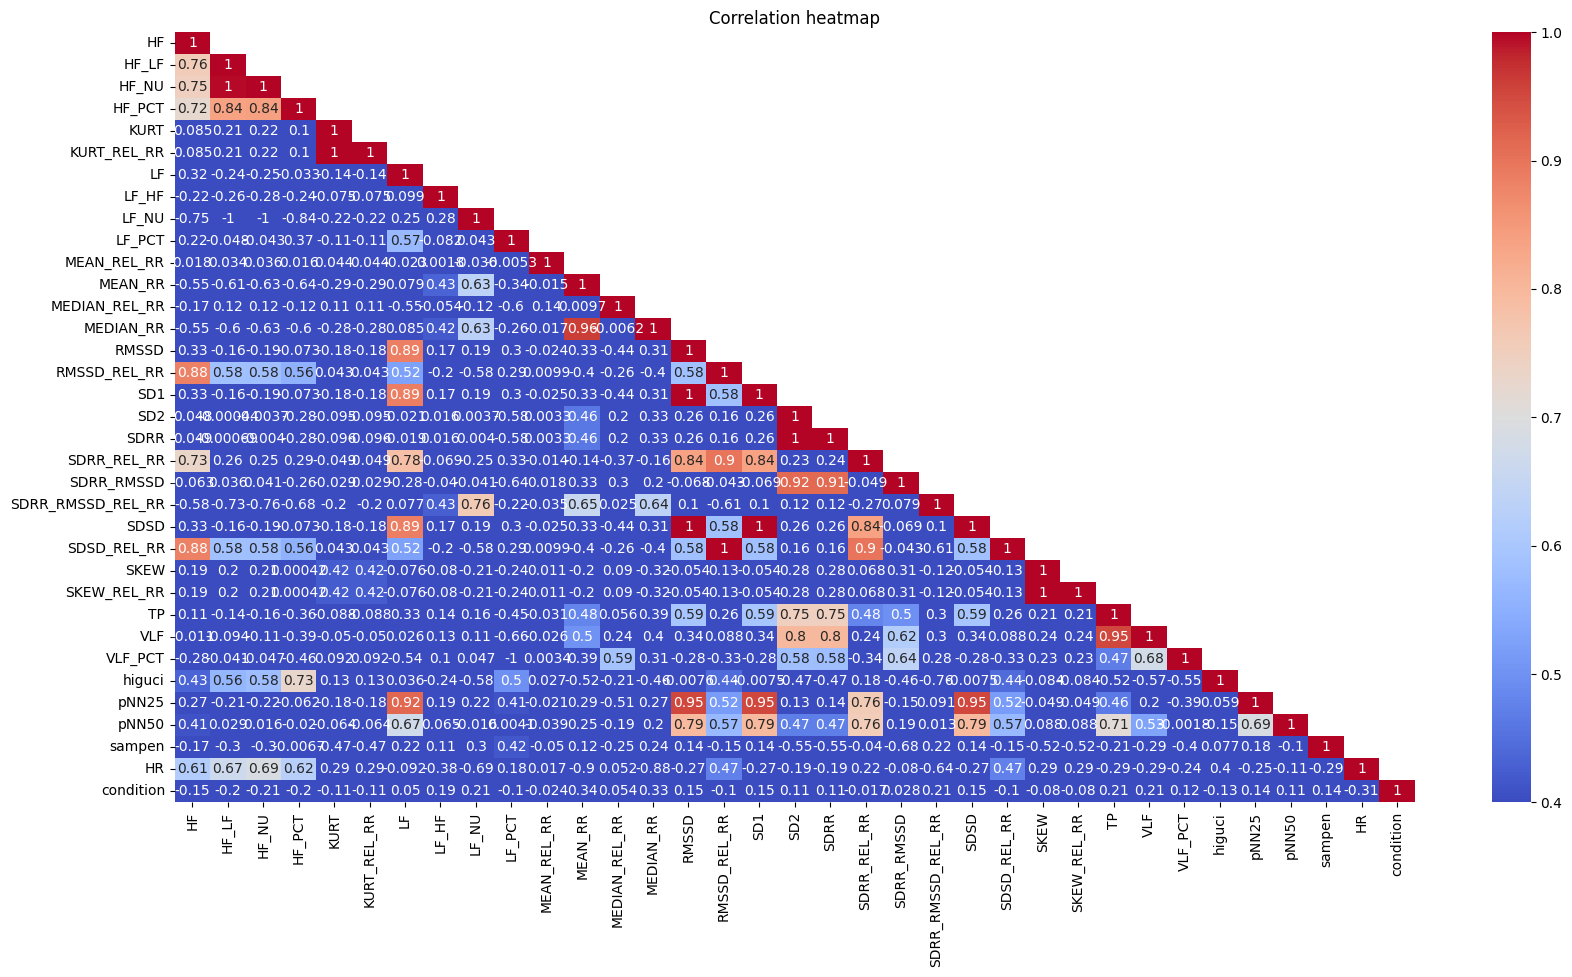

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_final_pdDF = df_final.toPandas()

correlation_matrix = df_final_pdDF.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(correlation_matrix,ax=ax, annot=True, cmap='coolwarm', vmin=0.4, mask=mask)
plt.title("Correlation heatmap")
plt.savefig('correlation.png')
plt.show()

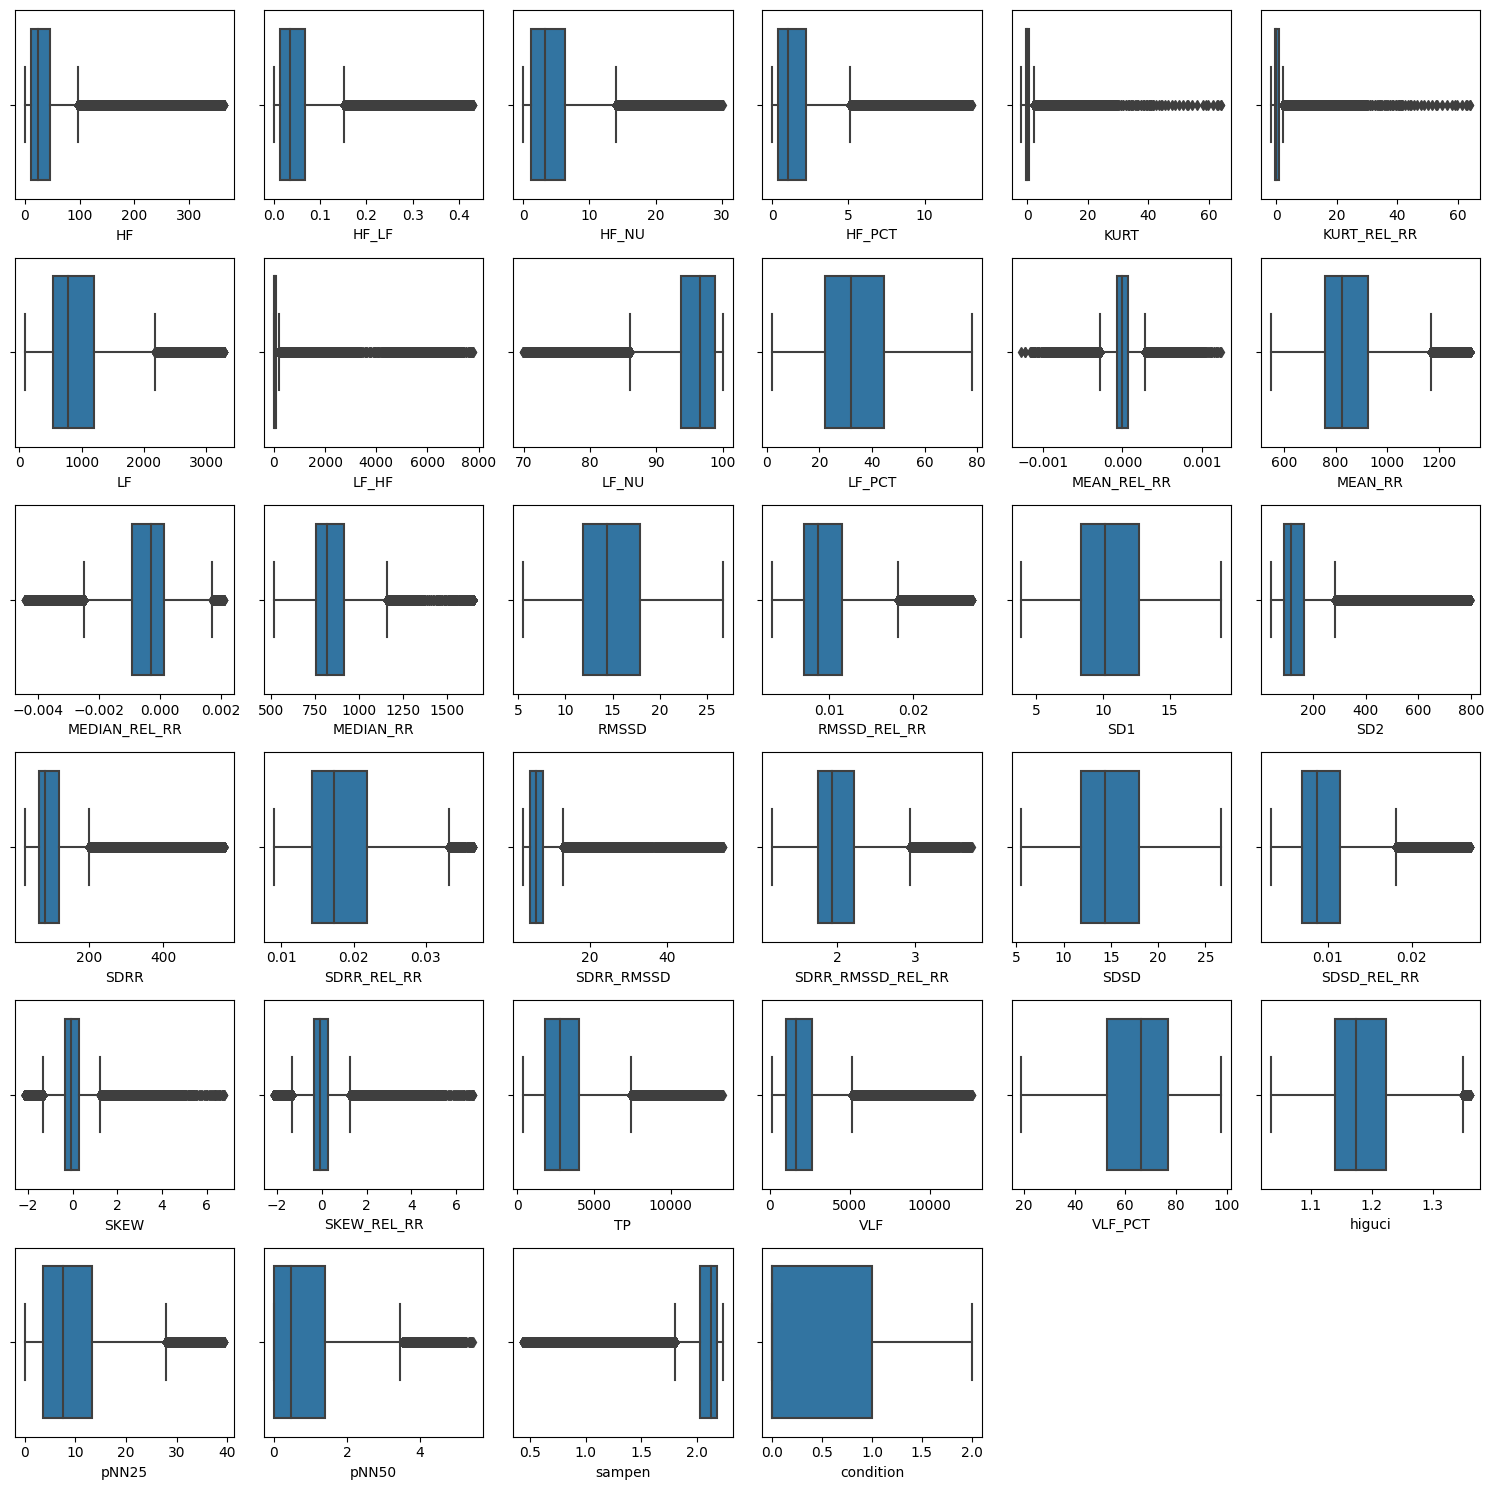

In [106]:
from math import sqrt, ceil

square = ceil(sqrt(len([col for col in df_final.columns if col not in ['HR']])))

fig, axs = plt.subplots(square, square, figsize=(15,15))
axs = axs.flatten()

for i, feature in enumerate([col for col in df_final.columns if col not in ['HR']]):
    sns.boxplot(x=df_final_pdDF[feature], ax=axs[i])
    axs[i].set_xlabel(feature)

if square ** 2 - len([col for col in df_final.columns if col not in ['HR']]) !=0:
    for i in range(1,1+(square ** 2 - len([col for col in df_final.columns if col not in ['HR']]))):
        fig.delaxes(axs[-i])
        
plt.tight_layout()
plt.savefig("boxplot.png")
plt.show()

# Priprema za trening

In [31]:
from pyspark.ml.feature import VectorAssembler

which_not_to_include = ['HR', "condition"]

assembler = VectorAssembler(
    inputCols=[column for column in df_final.columns if column not in which_not_to_include],
    outputCol="features")

assembled = assembler.transform(df_final)

In [32]:
from pyspark.ml.feature import RobustScaler

scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures")

scalerModel = scaler.fit(assembled)

scaledData = scalerModel.transform(assembled)
scaledData = scaledData.select("scaledFeatures", "HR")
scaledData

DataFrame[scaledFeatures: vector, HR: double]

In [33]:
train_data, test_data = scaledData.randomSplit([0.7,0.3])

In [34]:
from pyspark.ml.regression import LinearRegression

regressor = LinearRegression(featuresCol="scaledFeatures", labelCol="HR")

In [35]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regressor])

paramGrid = ParamGridBuilder() \
    .addGrid(regressor.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) \
    .addGrid(regressor.regParam, [0, 0.5, 1.5, 2]) \
    .addGrid(regressor.tol, [1e-06, 1e-04]) \
    .build()

crossValidation = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HR",metricName="r2"),
    numFolds=5
)

# Trening, testiranje i rezultati 

In [69]:
modelPath="model"

In [ ]:
try:
    from pyspark.ml.pipeline import PipelineModel
    trainedModel = PipelineModel.load(modelPath)
except Exception as e:
    trainedModel = crossValidation.fit(train_data)# fitujemo(treniramo) model nad trening skupom
    # trainedModel.bestModel.write().overwrite().save(modelPath) # Ne radi na Windowsu?

In [57]:
evaluator = trainedModel.getEvaluator()
estimator = trainedModel.getEstimator()

In [58]:
avgR2 = sum(trainedModel.avgMetrics)/len(trainedModel.avgMetrics)
print("Prosecan R2:\t",avgR2)

maxR2 = max(trainedModel.avgMetrics)
print("Najveci R2:\t",maxR2)

Prosecan R2:	 0.848910740084543
Najveci R2:	 0.8822412877662291


In [ ]:
from pprint import pprint
# for stage in crossValidationModel.bestModel.stages:
#     pprint(stage.extractParamMap())
pprint(trainedModel.bestModel.stages[0])


In [59]:
rmse = RegressionEvaluator(predictionCol="prediction", labelCol="HR", metricName="rmse")
mae= RegressionEvaluator(predictionCol="prediction", labelCol="HR", metricName="mae")
mse = RegressionEvaluator(predictionCol="prediction", labelCol="HR", metricName="mse")

In [60]:
output = trainedModel.transform(test_data)

In [80]:
output.show(10)

+--------------------+------------------+------------------+
|      scaledFeatures|                HR|        prediction|
+--------------------+------------------+------------------+
|[0.00205667165973...| 54.36380806894702| 63.15539652941118|
|[0.00218320919060...| 54.63486403460806|62.098173466515334|
|[0.00296358779943...| 52.29175209026432|58.228382287243775|
|[0.00308548221536...| 55.22026423883293| 60.70984123202579|
|[0.00361789987238...| 52.52957884361186| 57.43700246553919|
|[0.00363883788536...|  52.3337139873362| 57.04576808353206|
|[0.00367753673236...|  52.4194358889111| 57.11695955013199|
|[0.00373076512602...| 52.41865231825432| 57.01076656591754|
|[0.00430215266037...|56.114002643991526|59.852824047479984|
|[0.00508936537995...| 52.67295725960996| 55.69364852009199|
+--------------------+------------------+------------------+
only showing top 10 rows



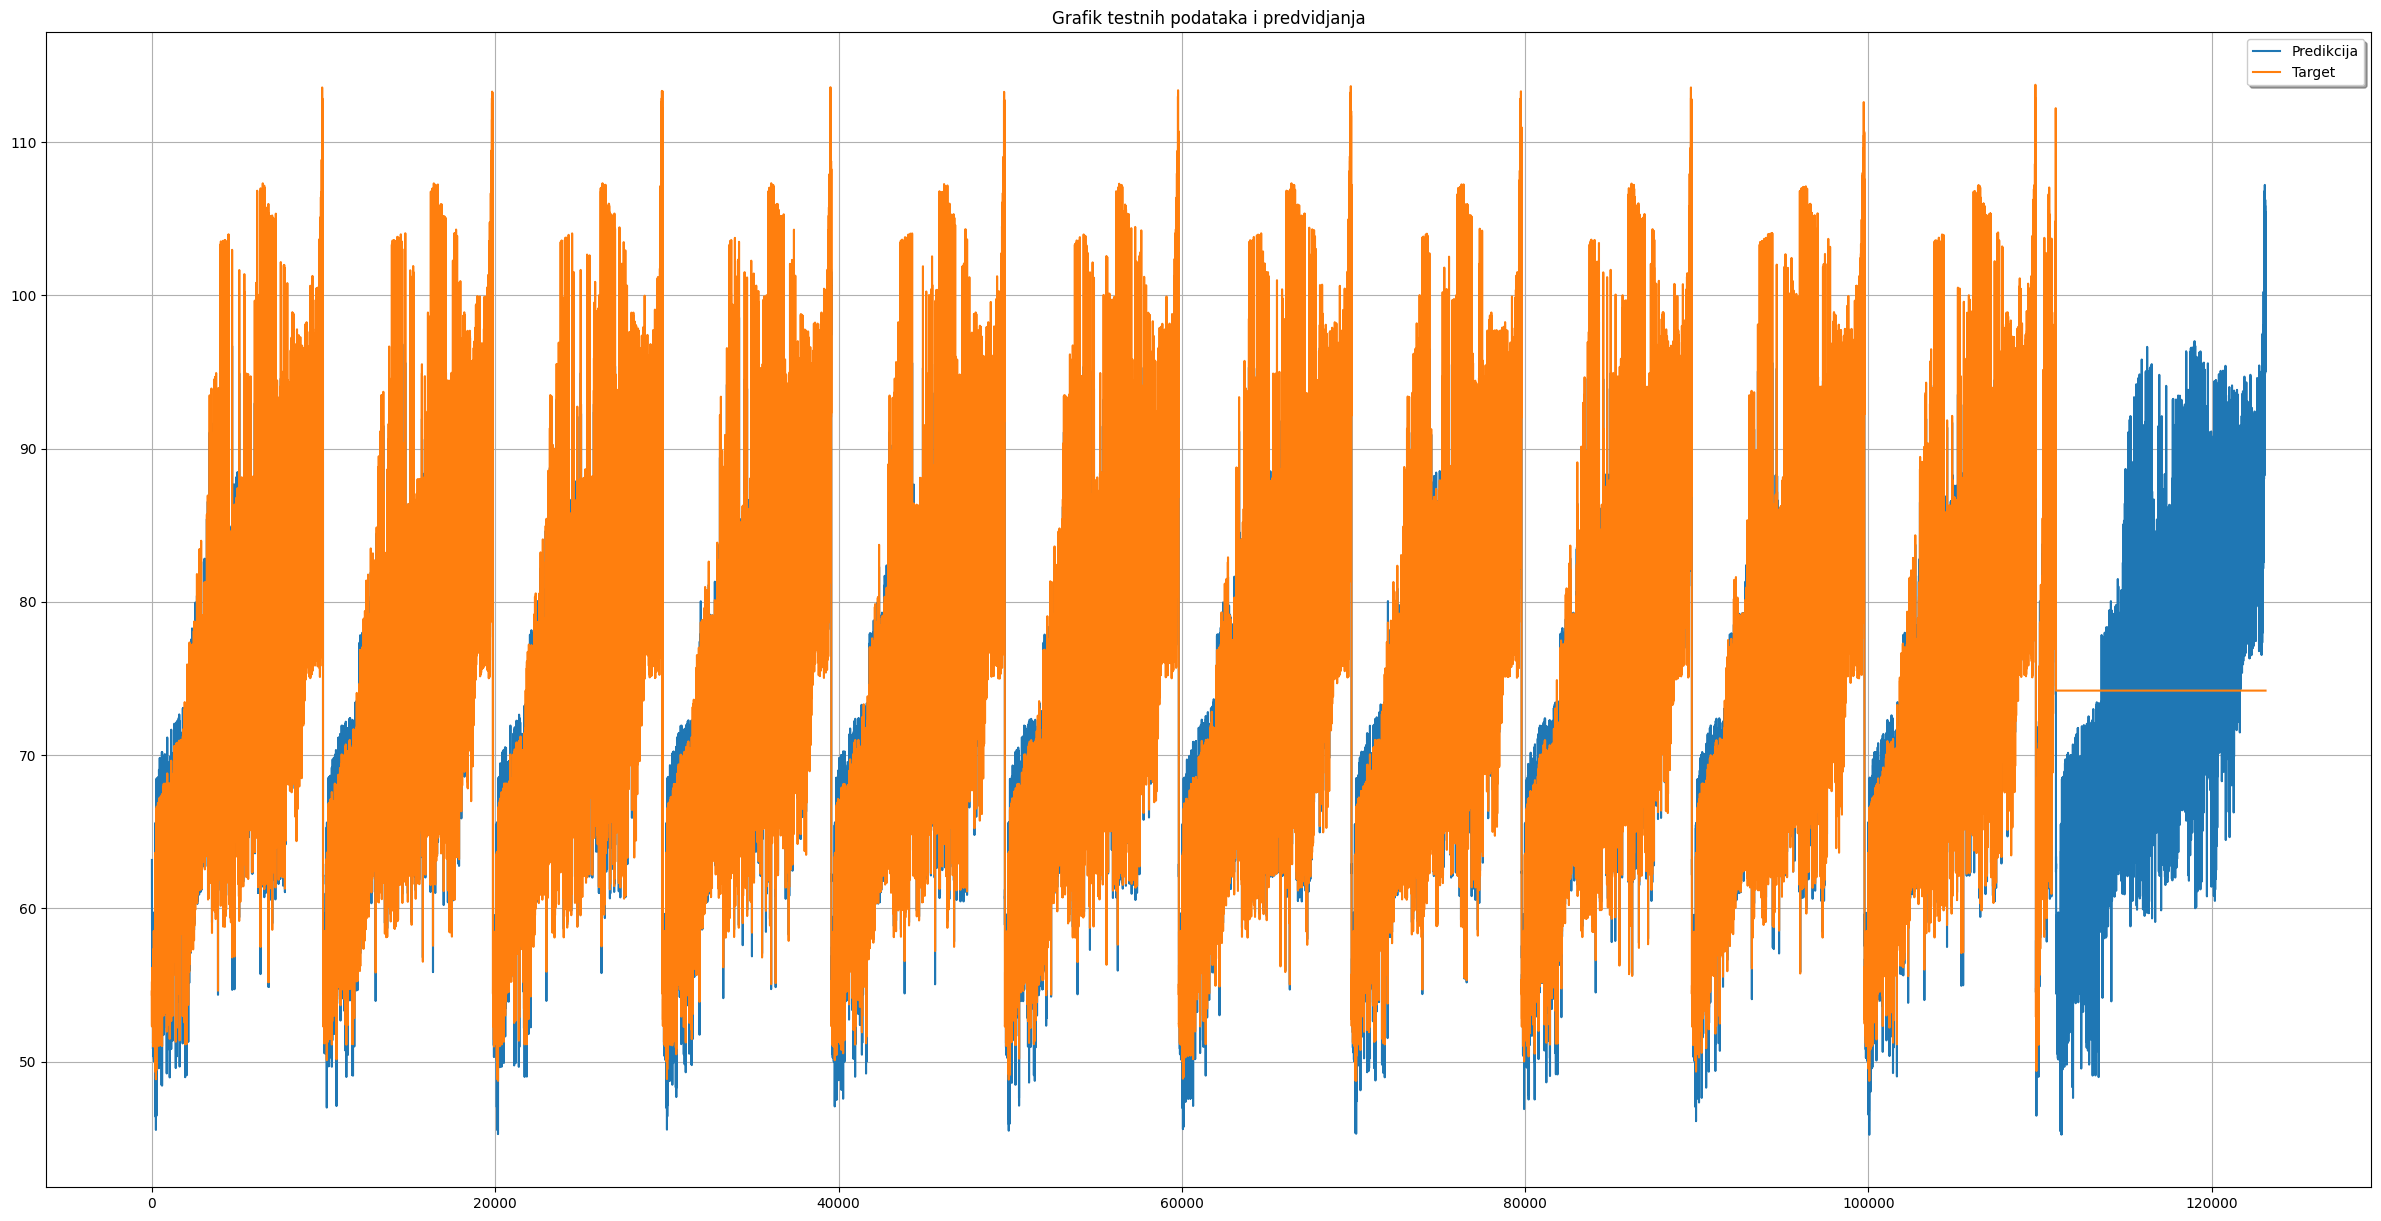

In [107]:
x_osa = range(0,output.count())
y_osa_predikcije = output.select('prediction').collect()
y_osa_target = output.select('HR').collect()

fig = plt.figure(figsize=(30,15))

plt.plot(x_osa, y_osa_predikcije, label="Predikcija")
plt.plot(x_osa, y_osa_target, label="Target")
plt.title("Grafik testnih podataka i predvidjanja")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.savefig('test.png')
plt.show()

In [61]:
print("R Squared (R2) on test data = %g" % evaluator.evaluate(output))
print("RMSE on test data = %g" % rmse.evaluate(output))
print("mae on test data = %g" % mae.evaluate(output))
print("mse on test data = %g" % mse.evaluate(output))

R Squared (R2) on test data = 0.884946
RMSE on test data = 3.32535
mae on test data = 1.77842
mse on test data = 11.058


|metric|value   |
|------|--------|
|R2    |0.882093|
|MAE   |1.78497 |
|MSE   |11.288  |
|RMSE  |3.35976 |